In [71]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.preprocessing import StandardScaler
from scipy.signal import medfilt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet
from tensorflow import keras

%load_ext autoreload
%autoreload 2
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%%html
<style>
table { align:left; display:block }
</style>

**Notebook Summary**
\
The CMAPSS datasets have simulated data from various different engines, which mimic the behavior from normal operation up until failure. There are 3 operational settings (OS1-3), 21 sensors and the time column (cycles). The unit column is simply the unit (engine) number. This notebook focuses on pre-processing, analyzing, modelling and predicting on the first CMAPSS dataset (FD001). The ultimate goal is to be able to predict how many cycles each engine will run before it experiences failure, which is known as Remaining Useful Life (RUL).

**Dataset: FD001**
* Train set engines: 100
* Test set engines: 100
* Operating condition: sea-level
* Fault mode: High Pressure Compressor (HPC) degradation
* Missing data: None

**Sensor Feature Descriptions**

| Name               | Description                    | Units   |
| ------------------ | ------------------------------ | ------- |
| fan_in_temp        | Total temp at fan inlet        | R       |
| lpc_out_temp       | Total temp at LPC outlet       | R       |
| hpc_out_temp       | Total temp at HPC outlet       | R       |
| lpt_out_temp       | Total temp at LPT outlet       | R       |
| fan_in_press       | Pressure at fan inlet          | psia    |
| bypass_press       | Total pressure in bypass duct  | psia    |
| hpc_out_press      | Total pressure at HPC outlet   | psia    |
| fan_speed          | Physical fan speed             | rpm     |
| core_speed         | Physical core speed            | rpm     |
| epr                | Engine pressure ratio (P50/P2) | N/A     |
| hpc_stat_press     | Static pressure at HPC outlet  | psia    |
| flow_press_ratio   | Ratio of fuel flow to Ps30     | pps/psi |
| corr_fan_speed     | Corrected fan speed            | rpm     |
| corr_core_speed    | Corrected core speed           | rpm     |
| bypass_ratio       | Bypass ratio                   | N/A     |
| burner_fuel_ratio  | Burner fuel-air ratio          | N/A     |
| bleed_enthalpy     | Bleed enthalpy                 | N/A     |
| dmd_fan_speed      | Demanded fan speed             | rpm     |
| dmd_corr_fan_speed | Demanded corrected fan speed   | rpm     |
| hpt_bleed          | HPT coolant bleed              | lbm/s   |
| lpt_bleed          | LPT coolant bleed              | lbm/s   |

In [3]:
df = pd.read_csv("train.csv")        # read data from csv
metadata = df.describe()             # get input metadata
print(metadata.loc["std",:])         # need to see which features do not change over time (~0 std dev)

unit                  2.922763e+01
cycles                6.888099e+01
OS1                   2.187313e-03
OS2                   2.930621e-04
OS3                   0.000000e+00
fan_in_temp           0.000000e+00
lpc_out_temp          5.000533e-01
hpc_out_temp          6.131150e+00
lpt_out_temp          9.000605e+00
fan_in_press          1.776400e-15
bypass_press          1.388985e-03
hpc_out_press         8.850923e-01
fan_speed             7.098548e-02
core_speed            2.208288e+01
epr                   0.000000e+00
hpc_stat_press        2.670874e-01
flow_press_ratio      7.375534e-01
corr_fan_speed        7.191892e-02
corr_core_speed       1.907618e+01
bypass_ratio          3.750504e-02
burner_fuel_ratio     1.387812e-17
bleed_enthalpy        1.548763e+00
dmd_fan_speed         0.000000e+00
dmd_corr_fan_speed    0.000000e+00
hpt_bleed             1.807464e-01
lpt_bleed             1.082509e-01
RUL                   6.888099e+01
Name: std, dtype: float64


In [4]:
"""
Remove features that do not change, as these will not be helpful in modelling the
output, and there is likely no insight to be gained from analyzing them
"""
df = pd.read_csv("train.csv")                           # read data from csv
remove_cols = ["OS3","fan_in_temp","epr",
               "dmd_fan_speed","dmd_corr_fan_speed"]    # these are true 0 st dev
df = df.drop(remove_cols, axis=1)                       # remove these cols
check_cols = ["fan_in_press","burner_fuel_ratio"]       # these cols have near 0 st dev
df[check_cols].describe()

,fan_in_press,burner_fuel_ratio
count,2.063100e+04,2.063100e+04
mean,1.462000e+01,3.000000e-02
std,1.776400e-15,1.387812e-17
min,1.462000e+01,3.000000e-02
25%,1.462000e+01,3.000000e-02
50%,1.462000e+01,3.000000e-02
75%,1.462000e+01,3.000000e-02
max,1.462000e+01,3.000000e-02


Total cols = 18


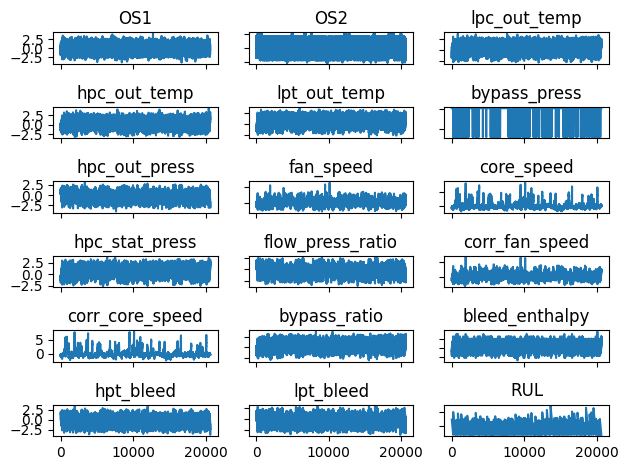

In [5]:
"""
These features above have 0 st dev, not 0 in pandas likely due to rounding error.
Now we select 
"""
df = pd.read_csv("train.csv")                           # read data from csv
remove_cols = ["OS3","fan_in_temp","epr",
               "dmd_fan_speed","dmd_corr_fan_speed",
               "fan_in_press","burner_fuel_ratio"]      # these haev 0 st dev
df = df.drop(remove_cols, axis=1)                       # drop more columns
cols = [c for c in df.columns.values if c not in ("unit","cycles")]
print(f"Total cols = {len(cols)}")

"""
We have 18 columns, so we can plot them on
a 3x6 matrix. For plotting purposes, we
z-score normalize all data so they can share
axes.
"""
def plot_matrix(df, cols, nrows, ncols):
    df.loc[:,cols] = StandardScaler().fit_transform(df[cols].to_numpy())
    fig, axs = plt.subplots(nrows, ncols)
    x_axis = list(range(df.shape[0]))
    for i, ax in enumerate(axs.flat):
        ax.plot(x_axis, df[cols[i]].to_numpy())
        ax.set_title(cols[i])
        ax.label_outer()
    fig.tight_layout()
    plt.show()

plot_matrix(df, cols, 6, 3)

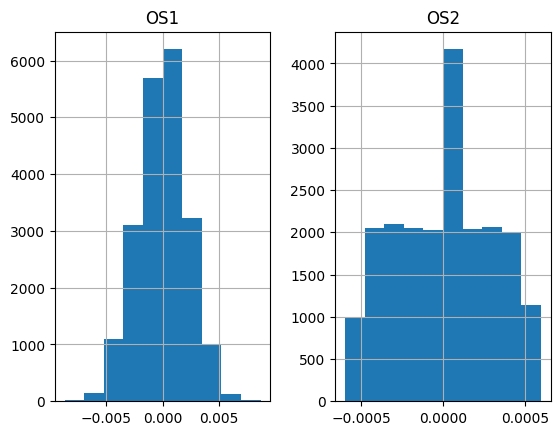

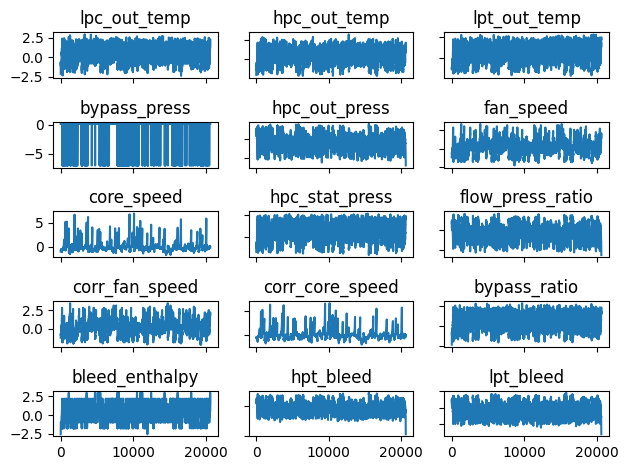

unit                0.078753
cycles             -0.736241
OS1                -0.003198
OS2                -0.001948
lpc_out_temp       -0.723273
hpc_out_temp       -0.723715
lpt_out_temp       -0.739201
bypass_press       -0.128348
hpc_out_press       0.718074
fan_speed          -0.604658
core_speed         -0.395677
hpc_stat_press     -0.738208
flow_press_ratio    0.720046
corr_fan_speed     -0.602806
corr_core_speed    -0.312148
bypass_ratio       -0.730192
bleed_enthalpy     -0.710795
hpt_bleed           0.727320
lpt_bleed           0.731487
RUL                 1.000000
Name: RUL, dtype: float64
                  lpc_out_temp  hpc_out_temp  lpt_out_temp  hpc_out_press  \
lpc_out_temp          1.000000      0.923012      0.942941      -0.935703   
hpc_out_temp          0.923012      1.000000      0.936432      -0.923778   
lpt_out_temp          0.942941      0.936432      1.000000      -0.956863   
hpc_out_press        -0.935703     -0.923778     -0.956863       1.000000   
hpc_stat_

In [6]:
df = pd.read_csv("train.csv")                           # read data from csv
remove_cols = ["OS3","fan_in_temp","epr",
               "dmd_fan_speed","dmd_corr_fan_speed",
               "fan_in_press","burner_fuel_ratio"]      # these haev 0 st dev
df = df.drop(remove_cols, axis=1)                       # drop more columns

"""
OS1 and OS2 are operational settings, so maybe it is not good
to filter them
"""
df[["OS1","OS2"]].hist()
plt.show()

"""
Most of the signals contain noise, so we will apply a median filter
in order to clean up some noise.
We will use an utility (from my utils.py file) to find the best
kernel to filter these signals. The kernel size will be chosen
such that it maximizes correlation to the "ref" column which in
our case will be our target variable, RUL.
"""
dont_filter = ["unit","cycles","OS1","OS2","RUL"]
cols = [c for c in df.columns.values if c not in dont_filter]
# this takes a while so it's better to just run once
# kernels = {}
# for c in cols:
#    kernels[c] = utils.find_best_kernel(df, c, "RUL")
# print(kernels)

# filter the noise from the signals, and revisualize them
# NOTE: 0 kernel means no filtering in this case
kernels = {'lpc_out_temp': 11, 'hpc_out_temp': 21, 'lpt_out_temp': 11, 
           'bypass_press': 0, 'hpc_out_press': 11, 'fan_speed': 11, 
           'core_speed': 11, 'hpc_stat_press': 11, 'flow_press_ratio': 11, 
           'corr_fan_speed': 11, 'corr_core_speed': 11, 'bypass_ratio': 11, 
           'bleed_enthalpy': 11, 'hpt_bleed': 21, 'lpt_bleed': 11}
for c in cols:
    if kernels[c] > 0:
        df.loc[:,c] = medfilt(df[c].to_numpy(), kernels[c])

plot_matrix(df, cols, 5, 3)

# we can look at which features are highly
# correlated to the target variable
print(df.corr()["RUL"])

# select features with > |0.7| correlation 
x_cols = ["lpc_out_temp","hpc_out_temp","lpt_out_temp","hpc_out_press",
          "hpc_stat_press","flow_press_ratio","bypass_ratio","bleed_enthalpy",
          "hpt_bleed","lpt_bleed"]

# we need to check which ones are highly correlated to each other
print(df[x_cols+["RUL"]].corr())

# top 4 are highly correlated to each other, but we will keep them in
# regardless as they correspond to different sections of the engine
x_cols = ["lpt_out_temp","hpc_stat_press","bypass_ratio","lpt_bleed"]
target = "RUL"
cols = x_cols + ["cycles","unit",target]
df = df.loc[:,cols]

# output as csv so we can load it back in
df.to_csv("data.csv", index=False)

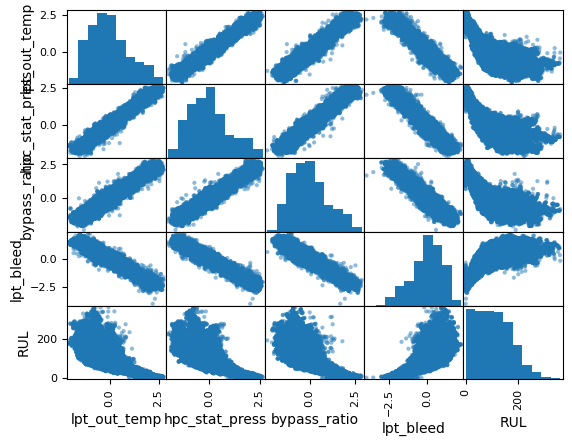

In [7]:
df = pd.read_csv("data.csv")

x_cols = ["lpt_out_temp","hpc_stat_press","bypass_ratio","lpt_bleed"]
target = "RUL"

# catch the output to suppress it
# _ because we won't use it
_ = pd.plotting.scatter_matrix(df[x_cols+[target]])

                 sqrtRUL       RUL
lpt_out_temp   -0.812685 -0.739201
hpc_stat_press -0.811609 -0.738208
bypass_ratio   -0.804579 -0.730192
lpt_bleed       0.803235  0.731487
RUL             0.972483  1.000000
sqrtRUL         1.000000  0.972483


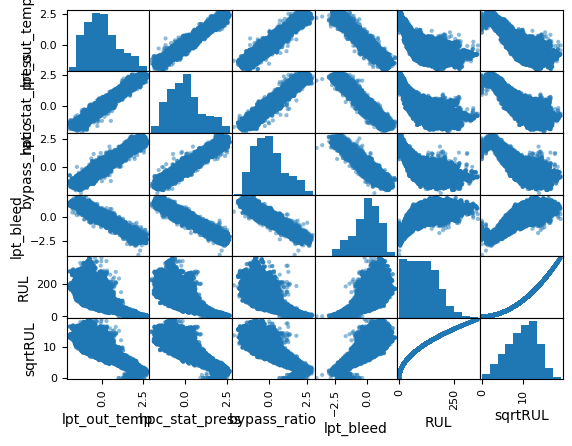

In [8]:
"""
We can see all of the column have a relationship to RUL
that appears to be polynomial. We can take the sqrt 
of RUL Then look at the scatter matrix again to see if 
the relationship is more linear
"""
df = pd.read_csv("data.csv")

x_cols = ["lpt_out_temp","hpc_stat_press","bypass_ratio","lpt_bleed"]
targets = ["RUL","sqrtRUL"]

df.loc[:,"sqrtRUL"] = np.sqrt(df["RUL"].to_numpy())
_ = pd.plotting.scatter_matrix(df[x_cols+targets])

print(df[x_cols+targets].corr()[["sqrtRUL","RUL"]])
df.to_csv("data.csv", index=False)

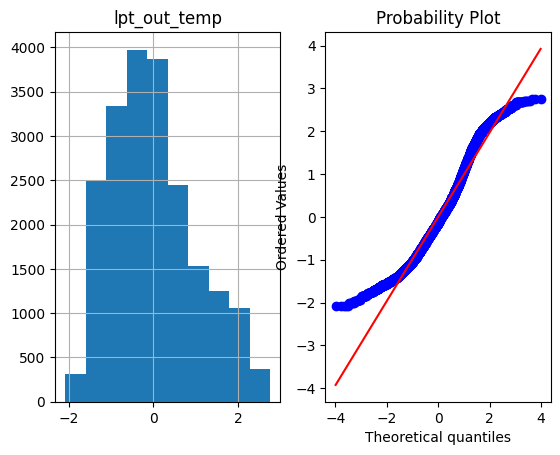

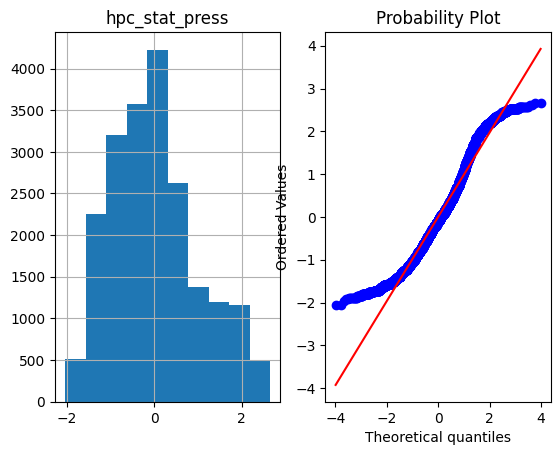

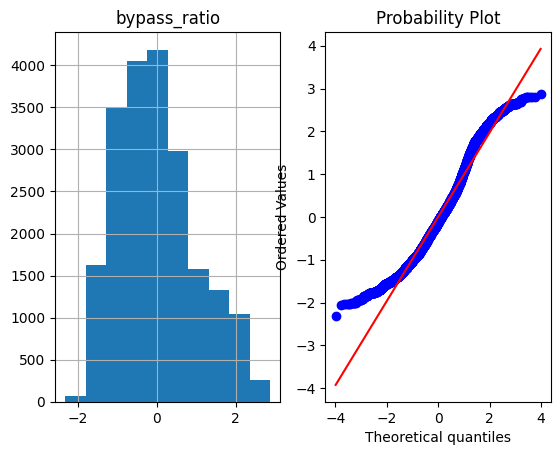

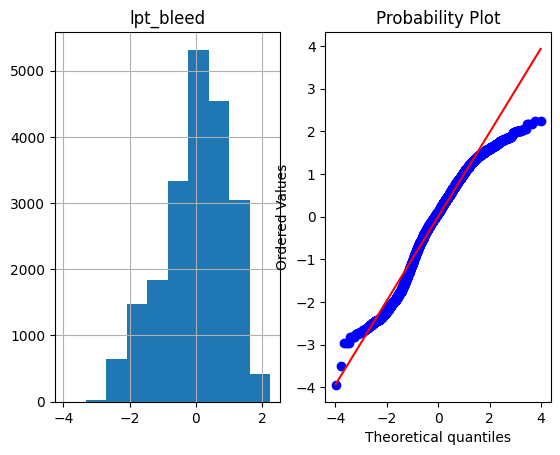

In [9]:
"""
We can see the relationships are now more linear, and consequently,
more highly correlated. We now look more closely at the four sensor
signals, which appear to have some skewness
"""
df = pd.read_csv("data.csv")

x_cols = ["lpt_out_temp","hpc_stat_press","bypass_ratio","lpt_bleed"]
targets = ["RUL","sqrtRUL"]

for c in x_cols:
    utils.hist_prob_plots(df, c)

lpt_out_temp lambda = 0.6284629101646589


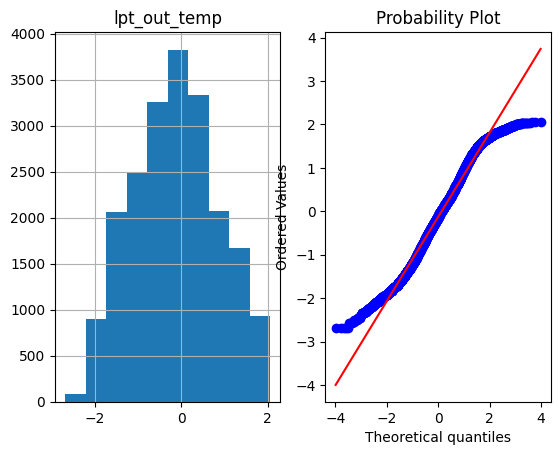

hpc_stat_press lambda = 0.6531862771608771


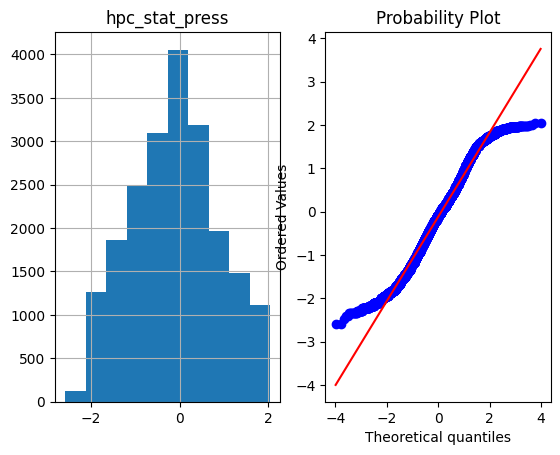

bypass_ratio lambda = 0.63236599660877


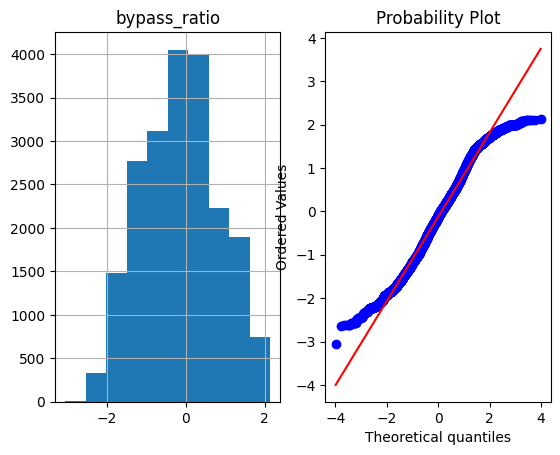

lpt_bleed lambda = 1.3487685276881247


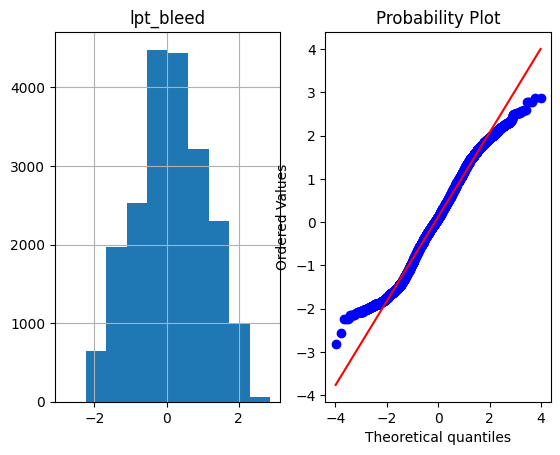

{'lpt_out_temp': 0.6284629101646589, 'hpc_stat_press': 0.6531862771608771, 'bypass_ratio': 0.63236599660877, 'lpt_bleed': 1.3487685276881247}


In [10]:
"""
There is some skew, so we will attempt transformation
to address it. We will use Yeo-Johnson transform, since
our data has a lot of negative values
"""
df = pd.read_csv("data.csv")

x_cols = ["lpt_out_temp","hpc_stat_press","bypass_ratio","lpt_bleed"]
targets = ["RUL","sqrtRUL"]

lambdas = {}

# transform and visualize again
for c in x_cols:
    xt, l = stats.yeojohnson(df[c].to_numpy())
    lambdas[c] = l
    print(f"{c} lambda = {l}")
    df.loc[:,c] = xt
    utils.hist_prob_plots(df, c)
print(lambdas)
df.to_csv("data.csv", index=False)

                lpt_out_temp  hpc_stat_press  bypass_ratio  lpt_bleed  \
lpt_out_temp        1.000000        0.964430      0.945465  -0.940240   
hpc_stat_press      0.964430        1.000000      0.951169  -0.948521   
bypass_ratio        0.945465        0.951169      1.000000  -0.930511   
lpt_bleed          -0.940240       -0.948521     -0.930511   1.000000   
cycles              0.661728        0.657397      0.649498  -0.656137   
unit                0.034486        0.032596      0.029249  -0.027222   
RUL                -0.729711       -0.729694     -0.720178   0.722883   
sqrtRUL            -0.785446       -0.786011     -0.777637   0.778235   

                  cycles      unit       RUL   sqrtRUL  
lpt_out_temp    0.661728  0.034486 -0.729711 -0.785446  
hpc_stat_press  0.657397  0.032596 -0.729694 -0.786011  
bypass_ratio    0.649498  0.029249 -0.720178 -0.777637  
lpt_bleed      -0.656137 -0.027222  0.722883  0.778235  
cycles          1.000000  0.078753 -0.736241 -0.754442  


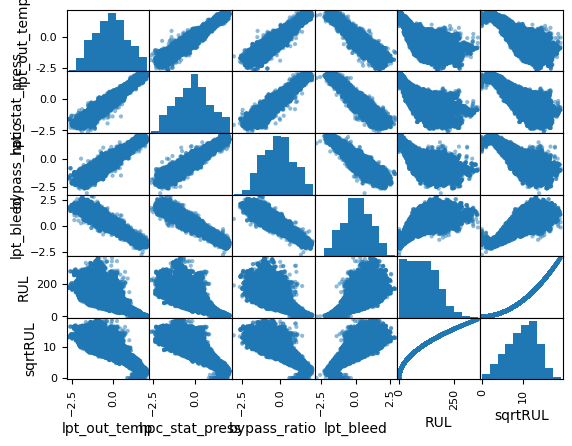

In [11]:
"""
Although the Q-Q plots are not perfect, we can
see from the histogram that the Y-J transform
has fixed the skews. We can visualize our
correlations and scatter matrix again
"""

df = pd.read_csv("data.csv")

x_cols = ["lpt_out_temp","hpc_stat_press","bypass_ratio","lpt_bleed"]
targets = ["RUL","sqrtRUL"]

print(df.corr())
_ = pd.plotting.scatter_matrix(df[x_cols+targets])

In [12]:
"""
Now we can look at adding some new features to the dataset,
like a derivative, since we have time series data
"""
df = pd.read_csv("data.csv")

x_cols = ["lpt_out_temp","hpc_stat_press","bypass_ratio","lpt_bleed"]
targets = ["RUL","sqrtRUL"]

dt = {'lpt_out_temp': 82, 'hpc_stat_press': 70, 
       'bypass_ratio': 86, 'lpt_bleed': 86}
# only need to run this once to get dt
# dt = {}
# for c in x_cols:
#    dt[c] = utils.find_best_dt(df, c, "RUL")
# print(dts)
for c in x_cols:
    df = utils.derivative_computer(df, c, dt[c], f"{c}_dx")
print(df.corr()["sqrtRUL"])
df.to_csv("data.csv", index=False)

lpt_out_temp        -0.785446
hpc_stat_press      -0.786011
bypass_ratio        -0.777637
lpt_bleed            0.778235
cycles              -0.754442
unit                 0.061475
RUL                  0.972483
sqrtRUL              1.000000
lpt_out_temp_dx     -0.815628
hpc_stat_press_dx   -0.825661
bypass_ratio_dx     -0.800952
lpt_bleed_dx         0.785480
Name: sqrtRUL, dtype: float64


In [13]:
"""
We can see the derivative (dx) features have high correlation
to the target and some even higher than the original features.
We can also check higher order derivatives, in this case we
can do the second order just to see
"""
dx_cols = ["lpt_out_temp_dx","hpc_stat_press_dx",
           "bypass_ratio_dx","lpt_bleed_dx"]
dt2 = {'lpt_out_temp_dx': 94, 'hpc_stat_press_dx': 100, 
       'bypass_ratio_dx': 98, 'lpt_bleed_dx': 102}
# only need to run this once to get dt2
# dt2 = {}
# for c in dx_cols:
#    dt2[c] = utils.find_best_dt(df, c, "RUL")
# print(dt2)
for c in dx_cols:
    df = utils.derivative_computer(df, c, dt2[c], f"{c}_dx")
print(df.corr()["sqrtRUL"])
df.to_csv("data.csv", index=False)

lpt_out_temp           -0.785446
hpc_stat_press         -0.786011
bypass_ratio           -0.777637
lpt_bleed               0.778235
cycles                 -0.754442
unit                    0.061475
RUL                     0.972483
sqrtRUL                 1.000000
lpt_out_temp_dx        -0.815628
hpc_stat_press_dx      -0.825661
bypass_ratio_dx        -0.800952
lpt_bleed_dx            0.785480
lpt_out_temp_dx_dx     -0.749248
hpc_stat_press_dx_dx   -0.754978
bypass_ratio_dx_dx     -0.756526
lpt_bleed_dx_dx         0.728096
Name: sqrtRUL, dtype: float64


In [31]:
"""
Now we need to make a preprocessing pipeline to 
apply to the test data so we can run some preds.
The sklearn Pipeline object is the preferred way,
but to keep it simple we will just make a function
to do it
"""
kernels = {'lpc_out_temp': 11, 'hpc_out_temp': 21, 'lpt_out_temp': 11, 
           'bypass_press': 0, 'hpc_out_press': 11, 'fan_speed': 11, 
           'core_speed': 11, 'hpc_stat_press': 11, 'flow_press_ratio': 11, 
           'corr_fan_speed': 11, 'corr_core_speed': 11, 'bypass_ratio': 11, 
           'bleed_enthalpy': 11, 'hpt_bleed': 21, 'lpt_bleed': 11}

lambdas = {'lpt_out_temp': 0.9808895569317668, 'hpc_stat_press': 0.9845431595886825, 
           'bypass_ratio': 0.9824291038810881, 'lpt_bleed': 1.0137365358393062}

dt = {'lpt_out_temp': 82, 'hpc_stat_press': 70, 
       'bypass_ratio': 86, 'lpt_bleed': 86}

dt2 = {'lpt_out_temp_dx': 94, 'hpc_stat_press_dx': 100, 
       'bypass_ratio_dx': 98, 'lpt_bleed_dx': 102}

def preprocessing_pipeline(df, cols, max_rul=125):
    # clip and sqrt RUL
    df.loc[:,"RUL"] = df["RUL"].clip(upper=max_rul)
    df.loc[:,"sqrtRUL"] = np.sqrt(df["RUL"].to_numpy())
    
    # filter and Y-J transform
    for c in cols:
        if c in kernels and kernels[c] > 0:
            df.loc[:,c] = medfilt(df[c].to_numpy(), kernels[c])
        if c in lambdas:
            xt = stats.yeojohnson(df[c].to_numpy(), lambdas[c])
            df.loc[:,c] = xt
    
    # derivatives
    for c in cols:
        dx_col = f"{c}_dx"
        df = utils.derivative_computer(df, c, dt[c], dx_col)
        df = utils.derivative_computer(df, dx_col, dt2[dx_col], f"{dx_col}_dx")

    return df

In [32]:
"""
Now we run the pipeline, scale the data, and we are
ready to try modelling our data.
"""
x_cols = ["lpt_out_temp","hpc_stat_press","bypass_ratio","lpt_bleed"]
dx_cols = ["lpt_out_temp_dx","hpc_stat_press_dx","bypass_ratio_dx","lpt_bleed_dx"]
ddx_cols = ["lpt_out_temp_dx_dx","hpc_stat_press_dx_dx","bypass_ratio_dx_dx","lpt_bleed_dx_dx"]
target = "sqrtRUL"
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
train = preprocessing_pipeline(train, x_cols)
test = preprocessing_pipeline(test, x_cols)
x_cols = ["cycles"] + x_cols + dx_cols + ddx_cols
cols = ["unit"] + x_cols + [target]
scaler = StandardScaler()
combo_df = pd.concat([train,test], ignore_index=True)
scaler.fit(combo_df[x_cols].to_numpy())
train.loc[:,x_cols] = scaler.transform(train[x_cols].to_numpy())
test.loc[:,x_cols] = scaler.transform(test[x_cols].to_numpy())

# we will use the last 20 engines as validation data
val = train.loc[train["unit"] > 80,:]

In [64]:
"""
We will build a function to train and eval
our models, using our validation data
"""
def train_and_eval_model(train, val, x_cols, target, model, paramset, score_func, n=5):
    best_params = None
    best_model = None
    best_score = np.inf
    for params in paramset:
        est = model(**params)
        est.fit(train[x_cols], train[target])
        y_pred = np.zeros(shape=(val.shape[0],))
        for _ in range(n):
            pred = est.predict(val[x_cols])
            pred = pred.reshape((pred.shape[0],))
            y_pred = np.add(y_pred,pred)
        y_pred = np.divide(y_pred, n)
        y_true = val[target].to_numpy()
        score = score_func(y_true, y_pred)
        if score <= best_score:
            best_score = score
            best_params = params
            best_model = est
            print(f"Params: {params}, score = {score}")
    return best_model, best_params, best_score

Params: {'fit_intercept': True}, score = 0.8265625794875404
{'fit_intercept': True}
Train Score = 0.8050112312350126
Val Score = 0.8265625794875404
Test Error = 0.6063050160244263


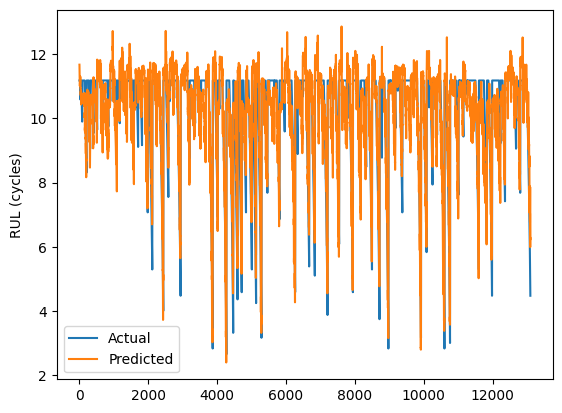

In [65]:
"""
First we will try a simple OLS model
"""
paramset = [{"fit_intercept": True}, {"fit_intercept": False}]
lm, params, best_score = train_and_eval_model(train, val, x_cols, "sqrtRUL", 
                                            LinearRegression, paramset, 
                                            mean_squared_error)
print(params)
y_train_pred = lm.predict(train[x_cols])
y_train_pred = y_train_pred.reshape((y_train_pred.shape[0],))
print(f"Train Score = {mean_squared_error(train[target].to_numpy(), y_train_pred)}")
print(f"Val Score = {best_score}")
y_pred = lm.predict(test[x_cols])
y_pred = y_pred.reshape((y_pred.shape[0],))
y_true = test[target].to_numpy()
err = mean_squared_error(y_true, y_pred)
print(f"Test Error = {err}")
x = list(range(y_pred.shape[0]))
plt.plot(x, y_true, label="Actual")
plt.plot(x, y_pred, label="Predicted")
plt.legend()
plt.ylabel("RUL (cycles)")
plt.show()

Params = 100
Params: {'alpha': 100.0}, score = 0.8320425790714859
{'alpha': 100.0}
Train Score = 0.8052835405598967
Val Score = 0.8320425790714859
Test Error = 0.6062535434454969


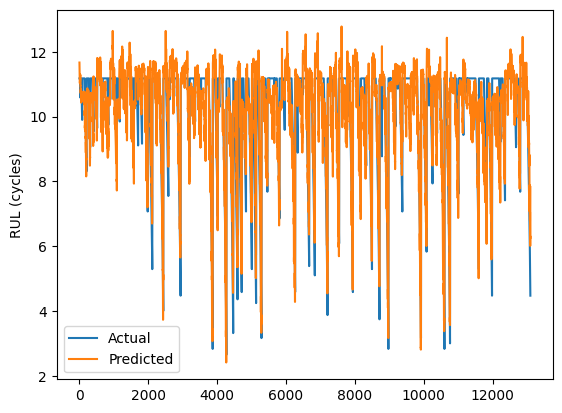

In [73]:
"""
We can see the OLS model is not too bad, it is likely overfitting
the training data a bit, but the percent different is < 12% so it
is not too bad.

Maybe we can do a little better. In the plot we can see the model
often undershoots for large RUL values, and overshoots for
small RUL values. We can try to tune a Ridge model to be a better
fit to our dataset
"""
alphas = np.linspace(100.0,1000.0,100)
paramset = [{"alpha": a} for a in alphas]
print(f"Params = {len(paramset)}")
lm, params, best_score = train_and_eval_model(train, val, x_cols, "sqrtRUL", 
                                            Ridge, paramset, 
                                            mean_squared_error)
print(params)
y_train_pred = lm.predict(train[x_cols])
y_train_pred = y_train_pred.reshape((y_train_pred.shape[0],))
print(f"Train Score = {mean_squared_error(train[target].to_numpy(), y_train_pred)}")
print(f"Val Score = {best_score}")
y_pred = lm.predict(test[x_cols])
y_pred = y_pred.reshape((y_pred.shape[0],))
y_true = test[target].to_numpy()
err = mean_squared_error(y_true, y_pred)
print(f"Test Error = {err}")
x = list(range(y_pred.shape[0]))
plt.plot(x, y_true, label="Actual")
plt.plot(x, y_pred, label="Predicted")
plt.legend()
plt.ylabel("RUL (cycles)")
plt.show()

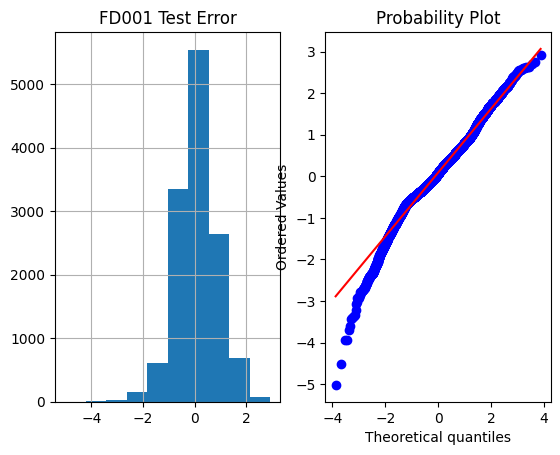

R^2 = 0.7584155920676483


In [74]:
"""
Ridge was a very small improvement, but we will
take it as our best estimator anyway. We can
look at the distribution of errors to confirm
that it is normally distributed. We can also check
the R^2 score to see how well the estimator
actually models our data
"""
errs = np.subtract(y_true, y_pred)
err_df = pd.DataFrame({"FD001 Test Error": errs})
utils.hist_prob_plots(err_df, "FD001 Test Error")
print(f"R^2 = {r2_score(y_true, y_pred)}")

Model error 90% conf interval = [-1.17420668678406, 1.4028788969152504]

hpc_stat_press_dx: -0.7979536735012278
lpt_out_temp_dx: -0.40777317438983723
lpt_out_temp: -0.3830890569697203
bypass_ratio_dx: -0.2951057317963732
lpt_bleed_dx: 0.22984901741794175
lpt_bleed: 0.19302700714656437
bypass_ratio: -0.1788174007279894
bypass_ratio_dx_dx: -0.15933885250380633
hpc_stat_press_dx_dx: 0.10176312675546455
cycles: 0.08423414539067077
hpc_stat_press: -0.03944597763480654
lpt_bleed_dx_dx: 0.030003722780279924
lpt_out_temp_dx_dx: -0.014097597330742933


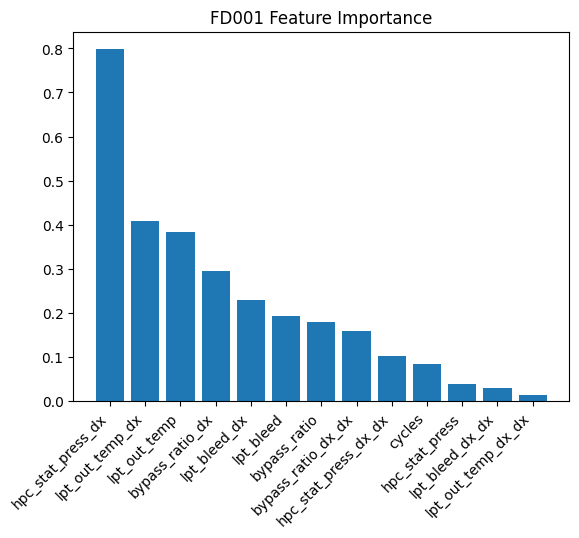

In [122]:
"""
This is a good R^2 score, and although there are some outliers
in the negative errors below -2, the error distribution is
generally normally distributed. We can say that this Ridge
Regressor accurately models the HPC degradation that is
represented in our dataset. Now we can look at some coefficients
to decided which features had the highest impact.
"""
err_ranges = [err_df["FD001 Test Error"].quantile(0.05), err_df["FD001 Test Error"].quantile(0.95)]
print(f"Model error 90% conf interval = {err_ranges}\n")
coeffs = [c for c, _ in sorted(zip(lm.coef_, x_cols), key=lambda pair: -1*abs(pair[0]))]
feats = [f for _, f in sorted(zip(lm.coef_, x_cols), key=lambda pair: -1*abs(pair[0]))]
for c, f in zip(coeffs, feats):
    print(f"{f}: {c}")
plt.bar(np.arange(0,len(coeffs),1), [abs(c) for c in coeffs])
ax = plt.gca()
ax.set_xticks([i for i in range(0,len(feats))])
ax.set_xticklabels(feats, rotation=45, horizontalalignment="right")
plt.title("FD001 Feature Importance")
plt.show()

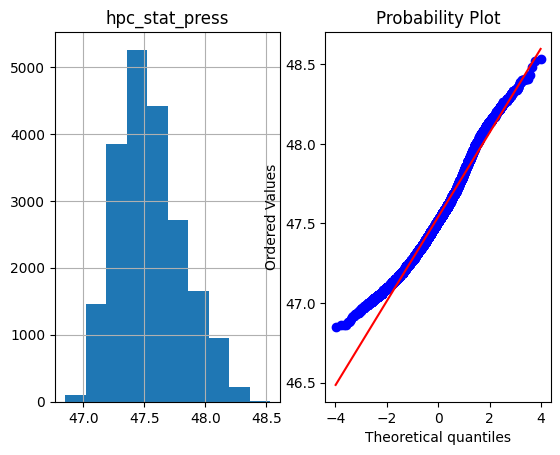

hpc_stat_press Metadata:
count    20631.000000
mean        47.541168
std          0.267087
min         46.850000
25%         47.350000
50%         47.510000
75%         47.700000
max         48.530000
Name: hpc_stat_press, dtype: float64

Top 5 Features Influencing hpc_stat_press
bypass_ratio        0.780913
fan_speed           0.782213
hpc_out_press      -0.822805
lpt_out_temp        0.830136
flow_press_ratio   -0.846884
hpc_stat_press      1.000000
Name: hpc_stat_press, dtype: float64


In [118]:
"""
Further insights for hpc_stat_press
"""
feat = "hpc_stat_press"
df = pd.read_csv("train.csv")
utils.hist_prob_plots(df, feat)
print(f"{feat} Metadata:")
print(df[feat].describe())
print(f"\nTop 5 Features Influencing {feat}")
print(df.corr().sort_values(feat, key=abs)[feat].dropna().tail(6))

**Discussion**
\
We can see that by far, the most important aspect of HPC degradation for these sets of engines is the rate of change of static pressure in the High Pressure Compressor (HPC). Specifically, the rate of change of hpc_stat_press has a negative relationship to remaining useful life. This means that as hpc_stat_pres_dx increases, RUL decreases. In other words, as the hpc_stat_press increases faster and faster, the RUL decrases faster and faster. Faster RUL decrease signifies faster HPC degradation. Other aspects that largely affect HPC degradation are the Low Pressure Turbine (LPT) temperature, and the rate of change of the temperature. These have a similar but lesser effect to hpc_stat_press, in fact they are each half as important as hpc_stat_press when contributing to HPC degradation.
\
\
**Recommendation**
\
Given our insights into the data and the predictions of our model, we can make some recommendations. Assuming that the ultimate goal would be to extend the time between services for the engine's HPC, we can do the following things in order to maximize that parameter:
1. Try to keep hpc_stat_press under 47.7 psia, when possible. This is the 75th percentile mark for this value. This may be done by keep lpt_out_temp, fan_speed and bypass_ratio as low as possible, while keeping flow_press_ratio and hpc_out_press as high as possible within the operating conditions.
2. When needing to increase hpc_stat_press, do it as slowly as possible within the operating conditions. Quick positive changes in hpc_stat_press have a huge negative effect on the health of HPC.
3. This model can be used to accurately predict HPC degradation. It accounts for about 75% of the variance in HPC degradation, and can generally predict predict RUL within (-4,4) with 90% confidence.